In [ ]:
!pip install lightgbm optuna
!pip install optuna-integration[lightgbm]
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import optuna
from optuna.integration import LightGBMPruningCallback
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Senior_Thesis_Waseda/exp_religion')

In [ ]:
%run ../evaluation.ipynb
%run ../training.ipynb
%run ../parameter_optimization.ipynb

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data.csv')
df.head()
df.shape

(97220, 82)

In [ ]:
income = pd.read_csv('/content/drive/MyDrive/Senior_Thesis_Waseda/happiness_data_pre_cluster.csv')
income = income.loc[:, ['D_INTERVIEW','Q173P']]
income.head()

,D_INTERVIEW,Q173P
0,196070011,3
1,196070036,3
2,196070039,3
3,196070040,3
4,196070053,3


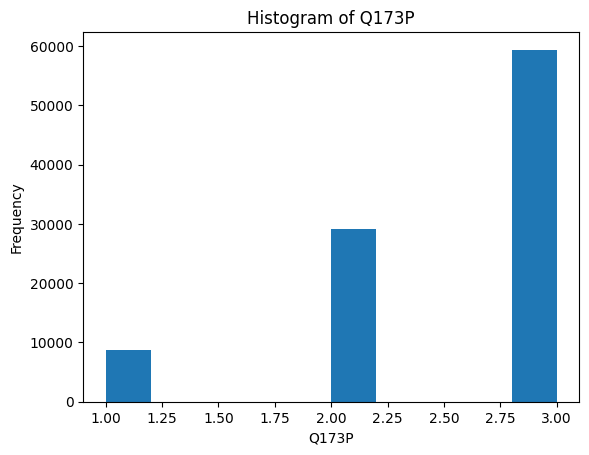

In [ ]:
import matplotlib.pyplot as plt

plt.hist(income['Q173P'])
plt.xlabel('Q173P')
plt.ylabel('Frequency')
plt.title('Histogram of Q173P')
plt.show()

In [ ]:
df_merged = pd.merge(income, df, on='D_INTERVIEW')
df_merged.head()

,D_INTERVIEW,Q173P,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
0,196070011,3,7.333333,CYP,6.0,1,4.0,0.936297,-0.623011,-1.308899,...,-1.675059,0.345000,0.976462,-1.848202,-1.456204,0.884878,2,1,6,3
1,196070036,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.580208,-0.332603,0.976462,-1.218074,-0.272563,0.884878,1,1,8,3
2,196070039,3,8.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.574066,0.146194,-0.200705,-0.266231,0.323946,0.268851,1,1,0,3
3,196070040,3,5.333333,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,-0.009851,0.143230,0.976462,-0.742153,-0.272563,0.884878,1,1,8,3
4,196070053,3,4.000000,CYP,6.0,1,4.0,0.936297,-0.623011,0.764001,...,0.507466,-0.300418,0.386842,0.839819,0.915767,0.268851,2,5,8,3


In [ ]:
df_merged = df_merged[df_merged['Q173P'] < 3]
df_merged.head()

,D_INTERVIEW,Q173P,happiness,B_COUNTRY_ALPHA,G_TOWNSIZE,GDP group,H_SETTLEMENT,Cl_1,Cl_2,Cl_3,...,Cl_67,Cl_68,Cl_69,Cl_70,Cl_71,Cl_72,Cl_73,Cl_74,Cl_75,Cl_76
10,196070154,2,8.666667,CYP,7.0,1,1.0,-1.068037,-0.623011,-1.308899,...,-0.999931,0.091762,0.098696,-0.266231,-1.456204,0.884878,1,6,8,3
14,196070307,2,8.000000,CYP,6.0,1,4.0,0.936297,1.605107,0.764001,...,-0.674996,0.345949,0.976462,-1.218074,-0.272563,0.884878,1,1,5,3
20,196070358,1,7.333333,CYP,1.0,1,5.0,0.936297,-0.623011,-1.308899,...,-0.400128,-0.333150,-1.066115,0.363897,0.321602,0.257307,3,6,0,0
24,218070005,2,10.000000,ECU,7.0,0,2.0,-1.068037,-0.623011,0.764001,...,-0.288682,0.303295,0.976462,-0.742153,-1.456204,0.884878,1,6,0,0
26,218070021,2,10.000000,ECU,7.0,0,2.0,-1.068037,1.605107,0.764001,...,0.127610,-0.097453,-0.492892,1.315740,0.323946,0.884878,2,6,4,1


In [ ]:
categorical = ['Cl_73', 'Cl_74', 'Cl_75', 'Cl_76']

for col in categorical:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
X = df_merged.loc[:, 'Cl_1':]
y = df_merged['happiness']

In [ ]:
parameter_optimization(X, y,
    save_path="exp_atheist_best_params.json")

[I 2025-06-15 05:52:44,210] A new study created in memory with name: lgbm_regression_opt


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379585
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.389311
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.388552
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.387017
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.383568


[I 2025-06-15 06:00:05,999] Trial 0 finished with value: 0.38560670246163825 and parameters: {'num_leaves': 37, 'learning_rate': 0.059662768998574464, 'max_depth': 12, 'reg_alpha': 0.01689821456403644, 'reg_lambda': 0.008733286960935062, 'feature_fraction': 0.5545578611806954, 'bagging_fraction': 0.7944205512826226, 'bagging_freq': 4, 'min_data_in_leaf': 483}. Best is trial 0 with value: 0.38560670246163825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.414703
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.423905
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.420274
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.41686
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.417056


[I 2025-06-15 06:09:42,397] Trial 1 finished with value: 0.41855935846362025 and parameters: {'num_leaves': 124, 'learning_rate': 0.008135993077935482, 'max_depth': 11, 'reg_alpha': 0.00016165526881359486, 'reg_lambda': 0.7035409156988579, 'feature_fraction': 0.4019026700531766, 'bagging_fraction': 0.5756856352296862, 'bagging_freq': 5, 'min_data_in_leaf': 459}. Best is trial 0 with value: 0.38560670246163825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.939963
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.939908
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.939254
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.938913
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.938308


[I 2025-06-15 06:21:11,416] Trial 2 finished with value: 0.9392694116737668 and parameters: {'num_leaves': 59, 'learning_rate': 0.0031419355583659327, 'max_depth': 9, 'reg_alpha': 8.662924996503568, 'reg_lambda': 0.02194583099502228, 'feature_fraction': 0.47397242771581266, 'bagging_fraction': 0.9496188320394634, 'bagging_freq': 7, 'min_data_in_leaf': 153}. Best is trial 0 with value: 0.38560670246163825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.49353
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.48658
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.48745
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.48802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.48686


[I 2025-06-15 06:27:24,677] Trial 3 finished with value: 1.4884874570290607 and parameters: {'num_leaves': 88, 'learning_rate': 0.0020393416894354194, 'max_depth': 3, 'reg_alpha': 0.004180382606157517, 'reg_lambda': 9.005175761589022, 'feature_fraction': 0.7078847726835956, 'bagging_fraction': 0.9258973847512997, 'bagging_freq': 1, 'min_data_in_leaf': 156}. Best is trial 0 with value: 0.38560670246163825.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376125
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.38519
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.385328
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381312
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380318


[I 2025-06-15 06:40:36,424] Trial 4 finished with value: 0.381654558309525 and parameters: {'num_leaves': 81, 'learning_rate': 0.03338461566965746, 'max_depth': 12, 'reg_alpha': 0.009228237972087388, 'reg_lambda': 4.420164028591646, 'feature_fraction': 0.6997672062599631, 'bagging_fraction': 0.8812298141809676, 'bagging_freq': 7, 'min_data_in_leaf': 251}. Best is trial 4 with value: 0.381654558309525.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.968211
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.972212
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.968156
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.970134
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.966932


[I 2025-06-15 06:52:04,102] Trial 5 finished with value: 0.9691290585795513 and parameters: {'num_leaves': 131, 'learning_rate': 0.0035756793567883233, 'max_depth': 6, 'reg_alpha': 0.0003352532574306502, 'reg_lambda': 0.04127989591553768, 'feature_fraction': 0.7891048128108265, 'bagging_fraction': 0.9397669501941917, 'bagging_freq': 1, 'min_data_in_leaf': 169}. Best is trial 4 with value: 0.381654558309525.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.382556
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.39223
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.391703
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.388866
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.387777


[I 2025-06-15 06:58:18,685] Trial 6 finished with value: 0.38862635112808996 and parameters: {'num_leaves': 30, 'learning_rate': 0.07511737052942642, 'max_depth': 12, 'reg_alpha': 0.0009040884568982261, 'reg_lambda': 5.889870175124454, 'feature_fraction': 0.6664289643882277, 'bagging_fraction': 0.5580546342887509, 'bagging_freq': 5, 'min_data_in_leaf': 200}. Best is trial 4 with value: 0.381654558309525.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.375158
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.382364
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383984
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379807
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.37939


[I 2025-06-15 07:13:39,120] Trial 7 finished with value: 0.3801406464303983 and parameters: {'num_leaves': 149, 'learning_rate': 0.021584729121977998, 'max_depth': 12, 'reg_alpha': 7.376024827825465, 'reg_lambda': 0.0008077586571489891, 'feature_fraction': 0.6648231984664661, 'bagging_fraction': 0.8036760300859622, 'bagging_freq': 5, 'min_data_in_leaf': 204}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.382846
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.391559
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.392269
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.388019
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.385979


[I 2025-06-15 07:24:10,620] Trial 8 finished with value: 0.38813420328819564 and parameters: {'num_leaves': 107, 'learning_rate': 0.027521448316098446, 'max_depth': 10, 'reg_alpha': 0.004026360901338699, 'reg_lambda': 0.000305705563511273, 'feature_fraction': 0.9006505683344346, 'bagging_fraction': 0.4151335109209015, 'bagging_freq': 2, 'min_data_in_leaf': 432}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27547
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27123
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27172
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 1.27022


[I 2025-06-15 07:32:08,116] Trial 9 finished with value: 1.2723038782238 and parameters: {'num_leaves': 26, 'learning_rate': 0.0024446594456802922, 'max_depth': 7, 'reg_alpha': 0.001499402648929466, 'reg_lambda': 0.006244650388242344, 'feature_fraction': 0.4870981102803031, 'bagging_fraction': 0.4813828127928418, 'bagging_freq': 1, 'min_data_in_leaf': 92}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:32:24,791] Trial 10 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379494
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.386348
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.388224
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.384879
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383171


[I 2025-06-15 07:44:21,465] Trial 11 finished with value: 0.3844231368428843 and parameters: {'num_leaves': 72, 'learning_rate': 0.028114034068820244, 'max_depth': 9, 'reg_alpha': 0.18049197303944922, 'reg_lambda': 0.34512409552326406, 'feature_fraction': 0.6296645942023187, 'bagging_fraction': 0.819810144023043, 'bagging_freq': 7, 'min_data_in_leaf': 284}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:44:44,375] Trial 12 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:45:53,445] Trial 13 pruned. Trial was pruned at iteration 250.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:46:16,170] Trial 14 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 07:46:41,688] Trial 15 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380266
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.387113
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.388549
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.384843
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.384381


[I 2025-06-15 08:00:03,224] Trial 16 finished with value: 0.3850304378360852 and parameters: {'num_leaves': 54, 'learning_rate': 0.04521189109160477, 'max_depth': 10, 'reg_alpha': 0.010061145548751751, 'reg_lambda': 1.7087530489429836, 'feature_fraction': 0.8624086565552432, 'bagging_fraction': 0.9987561539929737, 'bagging_freq': 4, 'min_data_in_leaf': 355}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:00:15,070] Trial 17 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:00:40,615] Trial 18 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:00:58,118] Trial 19 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:01:13,811] Trial 20 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376311
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.384174
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.385847
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.382627
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381184


[I 2025-06-15 08:12:29,788] Trial 21 finished with value: 0.3820286706773035 and parameters: {'num_leaves': 77, 'learning_rate': 0.039278950418040956, 'max_depth': 9, 'reg_alpha': 0.14154405943530612, 'reg_lambda': 0.2835833892843662, 'feature_fraction': 0.6345014591864532, 'bagging_fraction': 0.7960179725530865, 'bagging_freq': 7, 'min_data_in_leaf': 281}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.37668
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.385552
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.385694
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.38204
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.381593


[I 2025-06-15 08:24:22,155] Trial 22 finished with value: 0.3823116949087548 and parameters: {'num_leaves': 81, 'learning_rate': 0.04676998078903025, 'max_depth': 12, 'reg_alpha': 0.007933178836437677, 'reg_lambda': 0.217074541962206, 'feature_fraction': 0.7252140483203631, 'bagging_fraction': 0.759508442563944, 'bagging_freq': 7, 'min_data_in_leaf': 209}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.375766
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.385223
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.386407
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.383937
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.381531


[I 2025-06-15 08:35:44,206] Trial 23 finished with value: 0.38257281079945027 and parameters: {'num_leaves': 91, 'learning_rate': 0.04103250762123793, 'max_depth': 9, 'reg_alpha': 0.029136420576304948, 'reg_lambda': 1.6031421014353249, 'feature_fraction': 0.6714426247822578, 'bagging_fraction': 0.7539027784631227, 'bagging_freq': 6, 'min_data_in_leaf': 314}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:36:02,871] Trial 24 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:36:29,247] Trial 25 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 08:36:48,427] Trial 26 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[468]	valid's rmse: 0.379652
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[460]	valid's rmse: 0.389576
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[390]	valid's rmse: 0.38836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[421]	valid's rmse: 0.386003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[360]	valid's rmse: 0.383999


[I 2025-06-15 08:46:45,544] Trial 27 finished with value: 0.3855179592364312 and parameters: {'num_leaves': 77, 'learning_rate': 0.06892227014989585, 'max_depth': 11, 'reg_alpha': 0.0015868787295001796, 'reg_lambda': 0.1252988838261547, 'feature_fraction': 0.8303602500670144, 'bagging_fraction': 0.6610618990249767, 'bagging_freq': 7, 'min_data_in_leaf': 391}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.374931
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.383952
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383535
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380251
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380403


[I 2025-06-15 09:00:53,653] Trial 28 finished with value: 0.3806144914274464 and parameters: {'num_leaves': 114, 'learning_rate': 0.03317805262255236, 'max_depth': 12, 'reg_alpha': 0.1124995366016333, 'reg_lambda': 0.03617486874966931, 'feature_fraction': 0.6800650111988007, 'bagging_fraction': 0.8281896277523204, 'bagging_freq': 5, 'min_data_in_leaf': 262}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid's rmse: 0.374339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid's rmse: 0.384403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	valid's rmse: 0.385001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid's rmse: 0.381666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid's rmse: 0.379491


[I 2025-06-15 09:11:41,704] Trial 29 finished with value: 0.3809798826353118 and parameters: {'num_leaves': 143, 'learning_rate': 0.05773555104787926, 'max_depth': 12, 'reg_alpha': 0.016748804018540543, 'reg_lambda': 0.00701044696713841, 'feature_fraction': 0.6942335529559732, 'bagging_fraction': 0.83145617369267, 'bagging_freq': 4, 'min_data_in_leaf': 114}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid's rmse: 0.37362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[231]	valid's rmse: 0.386104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[325]	valid's rmse: 0.383461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid's rmse: 0.381475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid's rmse: 0.378347


[I 2025-06-15 09:20:08,562] Trial 30 finished with value: 0.38060153147125475 and parameters: {'num_leaves': 139, 'learning_rate': 0.06166476827744445, 'max_depth': 12, 'reg_alpha': 0.02068436492353106, 'reg_lambda': 0.005613260916303199, 'feature_fraction': 0.5350533732712575, 'bagging_fraction': 0.8150032854852175, 'bagging_freq': 4, 'min_data_in_leaf': 88}. Best is trial 7 with value: 0.3801406464303983.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.374085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	valid's rmse: 0.385983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid's rmse: 0.381022
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid's rmse: 0.37817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[379]	valid's rmse: 0.376926


[I 2025-06-15 09:30:49,458] Trial 31 finished with value: 0.3792372049157241 and parameters: {'num_leaves': 140, 'learning_rate': 0.05227829089365822, 'max_depth': 12, 'reg_alpha': 0.020562720191030094, 'reg_lambda': 0.006032643693445365, 'feature_fraction': 0.5402406102163559, 'bagging_fraction': 0.8281942398292207, 'bagging_freq': 4, 'min_data_in_leaf': 85}. Best is trial 31 with value: 0.3792372049157241.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid's rmse: 0.380376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[176]	valid's rmse: 0.388172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[249]	valid's rmse: 0.386629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid's rmse: 0.383925
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[222]	valid's rmse: 0.382967


[I 2025-06-15 09:35:33,933] Trial 32 finished with value: 0.3844137505146136 and parameters: {'num_leaves': 137, 'learning_rate': 0.09624201430135026, 'max_depth': 11, 'reg_alpha': 0.06793758841186322, 'reg_lambda': 0.0032293816328900554, 'feature_fraction': 0.42119049511097606, 'bagging_fraction': 0.7672674476218928, 'bagging_freq': 4, 'min_data_in_leaf': 47}. Best is trial 31 with value: 0.3792372049157241.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[345]	valid's rmse: 0.374112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid's rmse: 0.388601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[248]	valid's rmse: 0.385246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid's rmse: 0.38231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid's rmse: 0.379291


[I 2025-06-15 09:44:02,113] Trial 33 finished with value: 0.38191189357393346 and parameters: {'num_leaves': 125, 'learning_rate': 0.054047580497637936, 'max_depth': 12, 'reg_alpha': 0.028152410608607292, 'reg_lambda': 0.015483491721395962, 'feature_fraction': 0.5486676172780027, 'bagging_fraction': 0.7262107062791856, 'bagging_freq': 4, 'min_data_in_leaf': 70}. Best is trial 31 with value: 0.3792372049157241.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 09:44:23,086] Trial 34 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[436]	valid's rmse: 0.375379
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid's rmse: 0.385778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid's rmse: 0.384571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[353]	valid's rmse: 0.380112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[294]	valid's rmse: 0.379185


[I 2025-06-15 09:52:33,477] Trial 35 finished with value: 0.3810051656892484 and parameters: {'num_leaves': 140, 'learning_rate': 0.06807518919882585, 'max_depth': 12, 'reg_alpha': 0.003257298442995874, 'reg_lambda': 0.0007325720037567415, 'feature_fraction': 0.4600197697933375, 'bagging_fraction': 0.789055832979052, 'bagging_freq': 5, 'min_data_in_leaf': 170}. Best is trial 31 with value: 0.3792372049157241.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.373131
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.383298
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.381614
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.377582
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.37604


[I 2025-06-15 10:04:59,309] Trial 36 finished with value: 0.3783328995425989 and parameters: {'num_leaves': 122, 'learning_rate': 0.0319950361701989, 'max_depth': 12, 'reg_alpha': 0.014359499364360678, 'reg_lambda': 0.0034562223670151003, 'feature_fraction': 0.5492776752125973, 'bagging_fraction': 0.8304497256141159, 'bagging_freq': 3, 'min_data_in_leaf': 67}. Best is trial 36 with value: 0.3783328995425989.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.374628
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.384952
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383331
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.381715
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.377818


[I 2025-06-15 10:16:08,891] Trial 37 finished with value: 0.3804889264700188 and parameters: {'num_leaves': 132, 'learning_rate': 0.05398383447907934, 'max_depth': 11, 'reg_alpha': 0.01585599783798142, 'reg_lambda': 0.004197645149254146, 'feature_fraction': 0.551950700108032, 'bagging_fraction': 0.9031404804630255, 'bagging_freq': 3, 'min_data_in_leaf': 20}. Best is trial 36 with value: 0.3783328995425989.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:16:36,493] Trial 38 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 10:17:00,589] Trial 39 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[367]	valid's rmse: 0.373923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[354]	valid's rmse: 0.38572
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid's rmse: 0.383483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid's rmse: 0.380749
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid's rmse: 0.379658


[I 2025-06-15 10:26:19,177] Trial 40 finished with value: 0.380706446350786 and parameters: {'num_leaves': 121, 'learning_rate': 0.08155760812245752, 'max_depth': 11, 'reg_alpha': 0.005504247450871316, 'reg_lambda': 0.00016508147758250623, 'feature_fraction': 0.493229409761046, 'bagging_fraction': 0.9001157844527342, 'bagging_freq': 3, 'min_data_in_leaf': 148}. Best is trial 36 with value: 0.3783328995425989.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[405]	valid's rmse: 0.374035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid's rmse: 0.38506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid's rmse: 0.38269
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[330]	valid's rmse: 0.378788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[346]	valid's rmse: 0.377534


[I 2025-06-15 10:37:08,383] Trial 41 finished with value: 0.3796215615681767 and parameters: {'num_leaves': 144, 'learning_rate': 0.053671193262805526, 'max_depth': 12, 'reg_alpha': 0.01743124576240634, 'reg_lambda': 0.004608131753463608, 'feature_fraction': 0.5418388205069022, 'bagging_fraction': 0.8475882238455625, 'bagging_freq': 4, 'min_data_in_leaf': 80}. Best is trial 36 with value: 0.3783328995425989.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[443]	valid's rmse: 0.373086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid's rmse: 0.384298
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid's rmse: 0.38118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.378085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid's rmse: 0.376837


[I 2025-06-15 10:50:17,581] Trial 42 finished with value: 0.37869723967308344 and parameters: {'num_leaves': 145, 'learning_rate': 0.048134064662133505, 'max_depth': 12, 'reg_alpha': 0.002606464223867144, 'reg_lambda': 0.001639707303672627, 'feature_fraction': 0.5620014706290835, 'bagging_fraction': 0.9574813743395172, 'bagging_freq': 3, 'min_data_in_leaf': 79}. Best is trial 36 with value: 0.3783328995425989.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.3725
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.380883
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.381675
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.377325
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.377487


[I 2025-06-15 11:06:38,145] Trial 43 finished with value: 0.3779739906977734 and parameters: {'num_leaves': 144, 'learning_rate': 0.03607006387467977, 'max_depth': 12, 'reg_alpha': 0.0005917863029624189, 'reg_lambda': 0.0014918486254292393, 'feature_fraction': 0.6019171785284549, 'bagging_fraction': 0.9530575422318021, 'bagging_freq': 3, 'min_data_in_leaf': 135}. Best is trial 43 with value: 0.3779739906977734.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.372195
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.380812
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379915
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.377709
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376386


[I 2025-06-15 11:23:34,285] Trial 44 finished with value: 0.37740333422972827 and parameters: {'num_leaves': 144, 'learning_rate': 0.034490806387695486, 'max_depth': 12, 'reg_alpha': 0.0005887391293041399, 'reg_lambda': 0.0014762438786071824, 'feature_fraction': 0.5995000429756195, 'bagging_fraction': 0.9598696559595716, 'bagging_freq': 2, 'min_data_in_leaf': 134}. Best is trial 44 with value: 0.37740333422972827.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.372322
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.380995
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.381336
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.377939
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.377169


[I 2025-06-15 11:39:48,940] Trial 45 finished with value: 0.37795237066521237 and parameters: {'num_leaves': 135, 'learning_rate': 0.0341906114932251, 'max_depth': 10, 'reg_alpha': 0.0006325588140958622, 'reg_lambda': 0.0017388502919749966, 'feature_fraction': 0.6073927331462371, 'bagging_fraction': 0.9661077884934222, 'bagging_freq': 2, 'min_data_in_leaf': 135}. Best is trial 44 with value: 0.37740333422972827.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.372949
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381041
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.382256
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.37786
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.375989


[I 2025-06-15 11:54:43,929] Trial 46 finished with value: 0.3780190528987792 and parameters: {'num_leaves': 134, 'learning_rate': 0.03767707651089652, 'max_depth': 10, 'reg_alpha': 0.0006387017580544452, 'reg_lambda': 0.001743920353126419, 'feature_fraction': 0.5955692678411382, 'bagging_fraction': 0.9537949363911159, 'bagging_freq': 2, 'min_data_in_leaf': 136}. Best is trial 44 with value: 0.37740333422972827.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:55:10,534] Trial 47 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:55:33,666] Trial 48 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:56:01,151] Trial 49 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 11:56:19,756] Trial 50 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.371045
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.381857
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379969
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[489]	valid's rmse: 0.377217
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[491]	valid's rmse: 0.376407


[I 2025-06-15 12:09:52,496] Trial 51 finished with value: 0.37729919874538853 and parameters: {'num_leaves': 146, 'learning_rate': 0.03680527959940574, 'max_depth': 12, 'reg_alpha': 0.0016942426209843667, 'reg_lambda': 0.0014481862224024504, 'feature_fraction': 0.4960007498516489, 'bagging_fraction': 0.9537681853771435, 'bagging_freq': 2, 'min_data_in_leaf': 102}. Best is trial 51 with value: 0.37729919874538853.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.371043
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.381906
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.381382
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.376438
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.375928


[I 2025-06-15 12:23:23,489] Trial 52 finished with value: 0.3773393037608841 and parameters: {'num_leaves': 150, 'learning_rate': 0.03796955443824965, 'max_depth': 11, 'reg_alpha': 0.0010381255201695285, 'reg_lambda': 0.0013557258438362167, 'feature_fraction': 0.5022160446184475, 'bagging_fraction': 0.9412134011537254, 'bagging_freq': 2, 'min_data_in_leaf': 108}. Best is trial 51 with value: 0.37729919874538853.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:23:45,964] Trial 53 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.371525
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.380996
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.381201
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.37698
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.377373


[I 2025-06-15 12:36:57,222] Trial 54 finished with value: 0.3776149993241811 and parameters: {'num_leaves': 149, 'learning_rate': 0.03891780440758036, 'max_depth': 10, 'reg_alpha': 0.0009413419803905688, 'reg_lambda': 0.0012453406098331193, 'feature_fraction': 0.5077828055428538, 'bagging_fraction': 0.948234333674053, 'bagging_freq': 2, 'min_data_in_leaf': 182}. Best is trial 51 with value: 0.37729919874538853.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.37166
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381437
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.379173
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376335
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376193


[I 2025-06-15 12:47:15,959] Trial 55 finished with value: 0.376959581654716 and parameters: {'num_leaves': 150, 'learning_rate': 0.03817952438140115, 'max_depth': 11, 'reg_alpha': 0.0003771374424682365, 'reg_lambda': 0.0010875054777075945, 'feature_fraction': 0.4783971218406368, 'bagging_fraction': 0.9229955062271222, 'bagging_freq': 1, 'min_data_in_leaf': 192}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.372214
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383503
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid's rmse: 0.381016
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.376671
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376886


[I 2025-06-15 12:56:53,260] Trial 56 finished with value: 0.3780577950821594 and parameters: {'num_leaves': 150, 'learning_rate': 0.04301005244793424, 'max_depth': 9, 'reg_alpha': 0.001006155844078265, 'reg_lambda': 0.00022530166541643383, 'feature_fraction': 0.49987615690012965, 'bagging_fraction': 0.8737621881841551, 'bagging_freq': 1, 'min_data_in_leaf': 220}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:57:11,159] Trial 57 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 12:57:28,868] Trial 58 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[311]	valid's rmse: 0.374872
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[337]	valid's rmse: 0.384242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.383187
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid's rmse: 0.378682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid's rmse: 0.377598


[I 2025-06-15 13:06:39,491] Trial 59 finished with value: 0.37971612805542176 and parameters: {'num_leaves': 142, 'learning_rate': 0.07918367215300318, 'max_depth': 11, 'reg_alpha': 0.0021448930503578144, 'reg_lambda': 0.0003984074459542971, 'feature_fraction': 0.4054511329369375, 'bagging_fraction': 0.9816699294167914, 'bagging_freq': 2, 'min_data_in_leaf': 158}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:06:55,609] Trial 60 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:07:20,073] Trial 61 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.371494
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.381476
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.381638
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376555
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[485]	valid's rmse: 0.377226


[I 2025-06-15 13:17:05,228] Trial 62 finished with value: 0.37767786151552063 and parameters: {'num_leaves': 144, 'learning_rate': 0.04013255345545208, 'max_depth': 10, 'reg_alpha': 0.0011458586011054049, 'reg_lambda': 0.0024239149696734, 'feature_fraction': 0.4800045542469366, 'bagging_fraction': 0.9988108744017496, 'bagging_freq': 1, 'min_data_in_leaf': 226}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.372013
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.382859
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381563
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376694
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[472]	valid's rmse: 0.376105


[I 2025-06-15 13:26:43,552] Trial 63 finished with value: 0.3778466950147192 and parameters: {'num_leaves': 150, 'learning_rate': 0.04407939757100756, 'max_depth': 10, 'reg_alpha': 0.00024005458016717915, 'reg_lambda': 0.0023467930911206473, 'feature_fraction': 0.47292246102090296, 'bagging_fraction': 0.9964101168747989, 'bagging_freq': 1, 'min_data_in_leaf': 229}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.371985
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[476]	valid's rmse: 0.380802
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.381362
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.376443
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid's rmse: 0.376513


[I 2025-06-15 13:36:16,612] Trial 64 finished with value: 0.3774211665652766 and parameters: {'num_leaves': 146, 'learning_rate': 0.04292095117605966, 'max_depth': 9, 'reg_alpha': 0.00022451902426091233, 'reg_lambda': 0.002223623508879272, 'feature_fraction': 0.47579339745194715, 'bagging_fraction': 0.9978146684714453, 'bagging_freq': 1, 'min_data_in_leaf': 228}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:36:37,470] Trial 65 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:36:55,143] Trial 66 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.373089
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[488]	valid's rmse: 0.380978
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.383096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[429]	valid's rmse: 0.377355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid's rmse: 0.379002


[I 2025-06-15 13:45:11,005] Trial 67 finished with value: 0.37870395200123486 and parameters: {'num_leaves': 139, 'learning_rate': 0.06467960386812796, 'max_depth': 9, 'reg_alpha': 0.006335166219678489, 'reg_lambda': 0.00021998767128148504, 'feature_fraction': 0.4458438326549296, 'bagging_fraction': 0.9117919405315531, 'bagging_freq': 1, 'min_data_in_leaf': 276}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:45:29,354] Trial 68 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:45:45,634] Trial 69 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:46:27,620] Trial 70 pruned. Trial was pruned at iteration 169.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.371636
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380534
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.381507
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[482]	valid's rmse: 0.376773
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.376578


[I 2025-06-15 13:56:13,254] Trial 71 finished with value: 0.37740540871770756 and parameters: {'num_leaves': 150, 'learning_rate': 0.04326943626528401, 'max_depth': 10, 'reg_alpha': 0.000244881687313853, 'reg_lambda': 0.0023232360399847744, 'feature_fraction': 0.4609849951583307, 'bagging_fraction': 0.9752790621249504, 'bagging_freq': 1, 'min_data_in_leaf': 227}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 13:56:29,591] Trial 72 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.372182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid's rmse: 0.382931
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[471]	valid's rmse: 0.38257
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.377885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[472]	valid's rmse: 0.377427


[I 2025-06-15 14:05:21,582] Trial 73 finished with value: 0.3785988637492927 and parameters: {'num_leaves': 141, 'learning_rate': 0.06064845135891832, 'max_depth': 9, 'reg_alpha': 0.0007345609256954573, 'reg_lambda': 0.007374870889136501, 'feature_fraction': 0.49768712518511043, 'bagging_fraction': 0.936079394828305, 'bagging_freq': 1, 'min_data_in_leaf': 248}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.371207
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.382663
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[473]	valid's rmse: 0.381841
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[483]	valid's rmse: 0.375885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.37654


[I 2025-06-15 14:17:06,960] Trial 74 finished with value: 0.3776269595390965 and parameters: {'num_leaves': 146, 'learning_rate': 0.04271485259080762, 'max_depth': 11, 'reg_alpha': 0.0020450372542797123, 'reg_lambda': 0.0012264924066628419, 'feature_fraction': 0.4320975242124149, 'bagging_fraction': 0.8643185953563183, 'bagging_freq': 2, 'min_data_in_leaf': 191}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:17:23,634] Trial 75 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:17:42,925] Trial 76 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.372416
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[465]	valid's rmse: 0.381913
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[477]	valid's rmse: 0.380622
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid's rmse: 0.378493
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.377136


[I 2025-06-15 14:30:43,970] Trial 77 finished with value: 0.3781160089161181 and parameters: {'num_leaves': 147, 'learning_rate': 0.048105319032427034, 'max_depth': 12, 'reg_alpha': 0.0002767901211863374, 'reg_lambda': 0.0012267846591933456, 'feature_fraction': 0.5297729876857996, 'bagging_fraction': 0.915488189907475, 'bagging_freq': 3, 'min_data_in_leaf': 157}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[481]	valid's rmse: 0.371972
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.381747
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	valid's rmse: 0.382025
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[493]	valid's rmse: 0.375897
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.376746


[I 2025-06-15 14:43:38,804] Trial 78 finished with value: 0.37767712101627227 and parameters: {'num_leaves': 130, 'learning_rate': 0.04288673724488012, 'max_depth': 11, 'reg_alpha': 0.0001966901756862037, 'reg_lambda': 9.222840578752523, 'feature_fraction': 0.4601715861993517, 'bagging_fraction': 0.952535530366854, 'bagging_freq': 2, 'min_data_in_leaf': 201}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:43:52,823] Trial 79 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 14:44:08,926] Trial 80 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.371172
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.381979
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[484]	valid's rmse: 0.381987
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.376774
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[495]	valid's rmse: 0.376007


[I 2025-06-15 14:57:04,372] Trial 81 finished with value: 0.37758372709238025 and parameters: {'num_leaves': 131, 'learning_rate': 0.042986009553566754, 'max_depth': 11, 'reg_alpha': 0.0001720875743288796, 'reg_lambda': 0.06459823363595976, 'feature_fraction': 0.4584409494048203, 'bagging_fraction': 0.9448966550591803, 'bagging_freq': 2, 'min_data_in_leaf': 199}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.371809
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[494]	valid's rmse: 0.382972
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.380965
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.377252
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.376283


[I 2025-06-15 15:10:20,638] Trial 82 finished with value: 0.37785599531986336 and parameters: {'num_leaves': 135, 'learning_rate': 0.048983481155163995, 'max_depth': 12, 'reg_alpha': 0.00013624168426531666, 'reg_lambda': 0.046309075751810126, 'feature_fraction': 0.4914623899229562, 'bagging_fraction': 0.92484991963843, 'bagging_freq': 2, 'min_data_in_leaf': 210}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:10:38,638] Trial 83 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:11:00,662] Trial 84 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:11:20,338] Trial 85 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid's rmse: 0.372876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[441]	valid's rmse: 0.381502
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[456]	valid's rmse: 0.382217
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[425]	valid's rmse: 0.378641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid's rmse: 0.378174


[I 2025-06-15 15:24:09,316] Trial 86 finished with value: 0.37868197351375027 and parameters: {'num_leaves': 150, 'learning_rate': 0.05590644285460236, 'max_depth': 12, 'reg_alpha': 0.00047724792297906013, 'reg_lambda': 0.0014462081357462298, 'feature_fraction': 0.5000896958495502, 'bagging_fraction': 0.96135811069988, 'bagging_freq': 3, 'min_data_in_leaf': 172}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[480]	valid's rmse: 0.372901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid's rmse: 0.383649
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.383176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid's rmse: 0.378467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[332]	valid's rmse: 0.379081


[I 2025-06-15 15:34:04,405] Trial 87 finished with value: 0.3794547844080586 and parameters: {'num_leaves': 131, 'learning_rate': 0.06657867608005211, 'max_depth': 10, 'reg_alpha': 0.00019993096620450325, 'reg_lambda': 0.001875406156342619, 'feature_fraction': 0.47109848802089854, 'bagging_fraction': 0.9045318147616475, 'bagging_freq': 2, 'min_data_in_leaf': 218}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:34:21,904] Trial 88 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:34:45,210] Trial 89 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:35:02,600] Trial 90 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:36:07,674] Trial 91 pruned. Trial was pruned at iteration 203.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:36:27,864] Trial 92 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:37:18,166] Trial 93 pruned. Trial was pruned at iteration 135.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:37:42,857] Trial 94 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:38:05,708] Trial 95 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:38:31,452] Trial 96 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.371834
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.382289
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid's rmse: 0.382035
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid's rmse: 0.376228
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[490]	valid's rmse: 0.377074


[I 2025-06-15 15:47:31,843] Trial 97 finished with value: 0.3778920814580772 and parameters: {'num_leaves': 133, 'learning_rate': 0.044916581626188085, 'max_depth': 10, 'reg_alpha': 0.0018698803694601285, 'reg_lambda': 0.0030792852782741673, 'feature_fraction': 0.4361368996959785, 'bagging_fraction': 0.9239477068018832, 'bagging_freq': 1, 'min_data_in_leaf': 201}. Best is trial 55 with value: 0.376959581654716.


Training until validation scores don't improve for 50 rounds


[I 2025-06-15 15:47:57,287] Trial 98 pruned. Trial was pruned at iteration 50.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[450]	valid's rmse: 0.371213
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[459]	valid's rmse: 0.381739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid's rmse: 0.38122
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[464]	valid's rmse: 0.377752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[439]	valid's rmse: 0.379065


[I 2025-06-15 15:59:48,786] Trial 99 finished with value: 0.3781976686946194 and parameters: {'num_leaves': 147, 'learning_rate': 0.052065699020233176, 'max_depth': 11, 'reg_alpha': 0.0003800787536685752, 'reg_lambda': 0.8783666462407776, 'feature_fraction': 0.4645694118813299, 'bagging_fraction': 0.869519503007681, 'bagging_freq': 2, 'min_data_in_leaf': 111}. Best is trial 55 with value: 0.376959581654716.


In [ ]:
model, test_rmse= training(X, y,
    params_json_path="exp_atheist_best_params.json",
    save_model_path='exp_atheist_model.txt',
    save_log_filename="exp_atheist_log.csv")

Training until validation scores don't improve for 50 rounds
[50]	valid's rmse: 0.596518	valid's l2: 0.355834
[100]	valid's rmse: 0.412966	valid's l2: 0.170541
[150]	valid's rmse: 0.391407	valid's l2: 0.1532
[200]	valid's rmse: 0.386913	valid's l2: 0.149702
[250]	valid's rmse: 0.385013	valid's l2: 0.148235
[300]	valid's rmse: 0.38396	valid's l2: 0.147425
[350]	valid's rmse: 0.38314	valid's l2: 0.146796
[400]	valid's rmse: 0.382865	valid's l2: 0.146585
[450]	valid's rmse: 0.382601	valid's l2: 0.146384
[500]	valid's rmse: 0.382238	valid's l2: 0.146106
[550]	valid's rmse: 0.382019	valid's l2: 0.145938
[600]	valid's rmse: 0.381822	valid's l2: 0.145788
[650]	valid's rmse: 0.381739	valid's l2: 0.145724
[700]	valid's rmse: 0.381513	valid's l2: 0.145552
[750]	valid's rmse: 0.381363	valid's l2: 0.145438
[800]	valid's rmse: 0.381294	valid's l2: 0.145385
[850]	valid's rmse: 0.381268	valid's l2: 0.145365
Early stopping, best iteration is:
[844]	valid's rmse: 0.381226	valid's l2: 0.145333


In [ ]:
# Compute the standard deviation of y
std_y = y.std()
print(f"The standard deviation of y is: {std_y}")

In [ ]:
evaluation(model,
    X.sample(10000),
    name = "exp_atheist_results",
    max_display=30)

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>